In [1]:
# Import libraries
import json
from datetime import datetime
import pandas as pd

In [2]:
# Load posts data
with open('posts/your_posts_1.json') as f:
  data = json.load(f)

In [15]:
# View content format
#print(data)

In [4]:
# Data format
print(type(data))

<class 'list'>


In [5]:
# Explore few posts structure
print(data[10])
list(data[10])

{'timestamp': 1598357993, 'attachments': [{'data': [{'external_context': {'url': 'https://semanarural.com/web/articulo/polemica-por-la-patente-al-proceso-de-produccion-de-la-panela/1564'}}]}], 'data': [{'post': 'No han retirado la solicitud de patente del producto similar a panela, los paneleros continÃºan en firme con la oposiciÃ³n https://semanarural.com/web/articulo/polemica-por-la-patente-al-proceso-de-produccion-de-la-panela/1564'}, {'update_timestamp': 1598357993}]}


['timestamp', 'attachments', 'data']

In [6]:
# Library to correct accents and remove emoticons
import funciones

In [7]:
# Strip to the end
def right_char(text,char_stop,char_start):
    if text.find(char_stop,text.find(char_start)) == -1:
        return ""
    else:
        return text[text.find(char_stop,text.find(char_start)):]

In [8]:
# Remove mentions
def filter_mention(content):
    temp = content
    while temp.find("@") > -1:
        if temp.find("]",temp.find("@")) == -1:
            temp = ""
        else:
            temp = temp[:temp.find("@")] + temp[temp.find("]",temp.find("@"))+1:]
    return temp

# Remove urls
def filter_url(content):
    temp = content
    while temp.find("http") > -1:
        temp = temp[:temp.find("http")] + right_char(temp," ","http")
    return temp

In [9]:
# Fill dataframe with posts data with different dict formats

def fill_dataframe(start,stop,data_array):
    posts_array = []
    posts_raw_array = []
    fechas = []
    for i in range(start, stop):
        whole_dict = data_array[i]
        post_datetime = datetime.fromtimestamp(whole_dict['timestamp'])
        if 'data' in whole_dict:
            data_dict = whole_dict['data']
            if data_dict:
                post = data_dict[0]
                if list(post) == ['post']:
                    # Save post before changing chars format
                    posts_raw_array.append(post['post'])
                    # Clean post for Spanish and Analysis
                    post = funciones.accent_replace(post['post'])
                    post = funciones.emoticons_replace(post)
                    post = filter_mention(filter_url(post))
                    posts_array.append(post)
                    fechas.append(str(post_datetime))
                else:
                    post = "no_post"
            else:
                post = "no_post"
        elif 'attachments' in whole_dict:
            data_dict = whole_dict['attachments']
            data_media = data_dict[0]
            media_dict = data_media['data']
            media_detail = media_dict[0]
            media_data = media_detail['media']
            # Save post before changing chars format
            posts_raw_array.append(media_data['description'])
            # Clean post for Spanish and Analysis
            post = funciones.accent_replace(media_data['description'])
            post = funciones.emoticons_replace(post)
            post = filter_mention(filter_url(post))
            posts_array.append(post)
            fechas.append(str(post_datetime))
        else:
            post = "no_post"
    df_content = {'dates' : fechas[:], 'content': posts_array[:]}
    df = pd.DataFrame(df_content)
    # Create raw dataframe for saving
    df_raw_content = {'dates' : fechas[:], 'content': posts_raw_array[:]}
    df_raw = pd.DataFrame(df_raw_content)
    #print(df_raw)
    file_range = '-' + str(start) + '-' + str(stop)
    # Save raw data with empty posts stripped
    df_raw.to_csv(r'results/post_filtered' + file_range + '.csv', index = False)
    # Show dates included in the range
    print('Datos Desde: ' + df.loc[0,'dates'] + ' Hasta: ' + df.iloc[-1,0])
    return df

In [16]:
# Example of data processed
df = fill_dataframe(0,2000,data)
#df

Datos Desde: 2020-09-01 20:57:46 Hasta: 2020-01-19 11:39:12


In [11]:
# Import Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud, STOPWORDS

In [12]:
# Import NLP Spanish text
import spacy
nlp = spacy.load('es_core_news_sm')
nlp_en = spacy.load("en_core_web_sm")

# Import Stop Words from spacy
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_EN
stopwords_all = list(STOP_WORDS) + list(STOP_WORDS_EN)

# Review stop words
print(stopwords_all)

['demás', 'mismas', 'tus', 'sea', 'solamente', 'les', 'cualquier', 'debe', 'también', 'tiempo', 'horas', 'cuánta', 'suyo', 'hacemos', 'tercera', 'día', 'cuanta', 'muchos', 'algún', 'sigue', 'entre', 'actualmente', 'considera', 'vosotros', 'mis', 'ambos', 'según', 'aquél', 'mal', 'final', 'mientras', 'ir', 'sobre', 'estoy', 'dejó', 'nunca', 'tanto', 'cuantos', 'ningún', 'aquí', 'cuanto', 'más', 'mía', 'paìs', 'ayer', 'través', 'de', 'consigo', 'primero', 'allí', 'dado', 'ésa', 'creo', 'principalmente', 'hasta', 'deprisa', 'encima', 'sera', 'algo', 'dentro', 'medio', 'parece', 'aquella', 'hago', 'varias', 'así', 'como', 'dice', 'antaño', 'dan', 'mias', 'este', 'usamos', 'ha', 'míos', 'tuvo', 'realizar', 'alrededor', 'están', 'sin', 'alli', 'hacer', 'haya', 'adrede', 'va', 'era', 'explicó', 'apenas', 'siempre', 'estaba', 'solas', 'pocos', 'trabajo', 'la', 'intento', 'mucho', 'sabeis', 'varios', 'bajo', 'cuáles', 'dicen', 'quienes', 'estado', 'seis', 'tienen', 'uso', 'esto', 'cinco', 'empl

In [13]:
# Create plot configuration

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None

# Create word cloud
def wordcloud(array,col,idgraf):
    #Crear la imagen con las palabras más frecuentes
    wordcloud = WordCloud(background_color="white",stopwords=stopwords_all,random_state = 42).generate(" ".join([i for i in array[col]]))
    #Preparar la figura
    plt.figure(num=idgraf, figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Posts Word Cloud+")

Datos Desde: 2020-09-01 20:57:46 Hasta: 2020-03-31 11:40:39
Datos Desde: 2019-06-10 20:08:56 Hasta: 2019-03-21 15:01:51


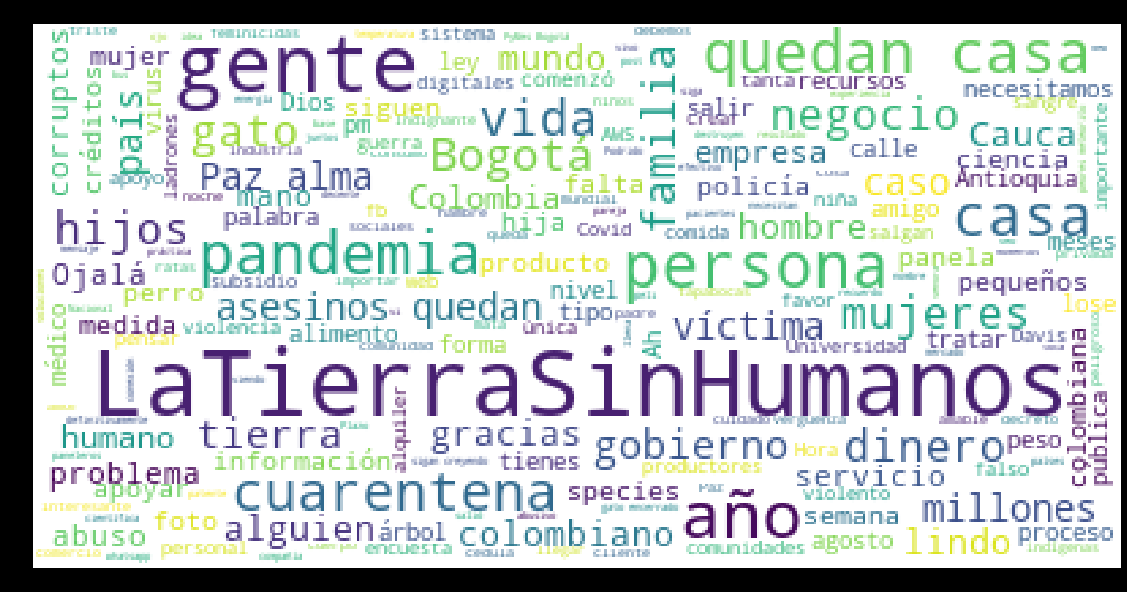

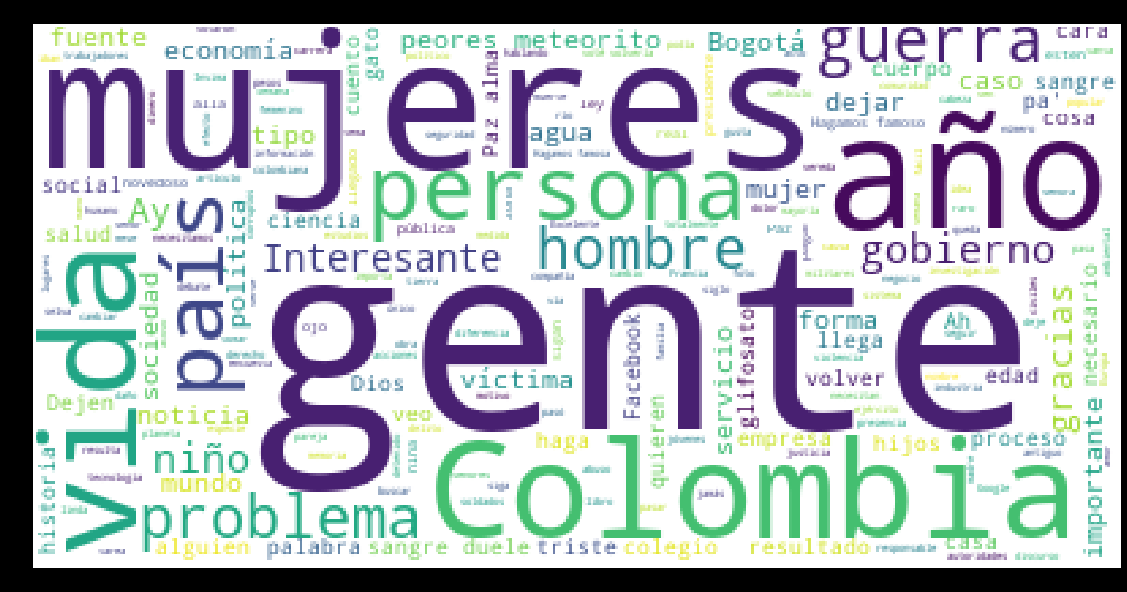

In [14]:
# Create two word clouds with different time frame in order to compare

wordcloud(fill_dataframe(0,1400,data),'content',100)
wordcloud(fill_dataframe(5000,6400,data),'content',200)
